# BEE 4750 Lab 4: Simulation-Optimization

**Name**: Anthony Nicolaides

**ID**: ajn68

> **Due Date**
>
> Friday, 11/17/23, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Documents/Julia/BEE4750/labs/lab04-anthonynic28`


In [2]:
using Random # for random seeds
using Distributions # statistical distribution interface
using Roots # find zeros of functions
using Metaheuristics # search algorithms
using Plots # plotting

## Overview

In this lab, you will experiment with simulation-optimization with the
shallow lake problem. The goal of this experimentation is to get an
understanding of how to work with simulation-optimization methods and
the impact of some choices involved in using these methods.

Free free to delete some of the illustrative cells and code blocks in
your notebook as you go through and solve the lab problems…this might
help reduce some potential confusion while grading about what your
answer is.

## Introduction

Due to ongoing economic activity, a town emits phosphorous into a
shallow lake (with a concentration of $a_t$), which also receives
non-point source runoff (concentration $y_t$) from the surrounding area.
The concentration of the lake at time $t+1$ is given by
$$X_{t+1} = X_t + a_t + y_t + \frac{X_t^q}{1+X_t^q} - bX_t,$$

where:

| Parameter | Value                                                |
|:---------:|:-----------------------------------------------------|
|   $a_t$   | point-source phosphorous concentration from the town |
|   $y_t$   | non-point-source phosphorous concentration           |
|    $q$    | rate at which phosphorous is recycled from sediment  |
|    $b$    | rate at which phosphorous leaves the lake            |

and $X_0 = 0$, $y_t \sim LogNormal(\log(0.03), 0.25)$, $q=2.5$, and
$b=0.4$.

The goal of the optimization is to maximize the town’s average
phosphorous concentration releases (as a proxy of economic activity):
$\max \sum_{t=1}^T a_t / T$ over a 100-year period. We have decided
(initially) that an acceptable solution is one which will result in the
lake eutrophying no more than 10% of the time.

The non-point source samples can be sampled using the following code
block:

In [3]:
Random.seed!(1)

T = 100 # length of simualtion
n_samples = 1_000 # replace with number of samples if you experiment

# add q and b
q = 2.5
b = 0.4

P_distribution = LogNormal(log(0.03), 0.25)
y = rand(P_distribution, (T, n_samples)) # sample a T x n_samples matrix

100×1000 Matrix{Float64}:
 0.0294753  0.0459864  0.023513   …  0.0259183  0.0260934  0.0284652
 0.034263   0.0222782  0.0459188     0.0288482  0.0480454  0.0531018
 0.0245199  0.0296271  0.0445619     0.0246404  0.0250734  0.0304308
 0.055448   0.0312     0.0228208     0.0298609  0.0428105  0.0256198
 0.0401417  0.024978   0.0458244     0.0228935  0.0286062  0.0238694
 0.0320754  0.021759   0.0471452  …  0.0472771  0.0187508  0.0306753
 0.0464641  0.0416385  0.0246833     0.0382252  0.0288505  0.0226561
 0.0244027  0.0432707  0.0341214     0.0238988  0.0427204  0.0316143
 0.0231156  0.0279197  0.0217747     0.0231772  0.0335662  0.0324465
 0.0276303  0.0305858  0.0440326     0.0289394  0.0312328  0.0173388
 ⋮                                ⋱                        
 0.025665   0.0341366  0.0274747     0.0283546  0.0458031  0.0277959
 0.0405629  0.0421121  0.0252557     0.0450377  0.0284411  0.0206434
 0.0228445  0.0223746  0.0210942     0.0442834  0.0337672  0.0287835
 0.0252604  0.046

We write the lake model as a function:

In [4]:
# lake function model
# inputs:
#   a: vector of point-source releases (to be optimized)
#   y: randomly-sampled non-point sources
#   q: lake phosphorous recycling rate
#   b: phosphorous outflow rate
# 
# returns:
#   series of lake phosphorous concentrations
function lake(a, y, q, b, T)
    X = zeros(T + 1, size(y, 2))
    # calculate states
    for t = 1:T
        X[t+1, :] = X[t, :] .+ a[t] .+ y[t, :] .+ (X[t, :] .^ q ./ (1 .+ X[t, :] .^ q)) .- b .* X[t, :]
    end
    return X
end

lake (generic function with 1 method)

However, this isn’t sufficient on its own! `Metaheuristics.jl` (and most
simulation-optimization packages) require the use of a *wrapper*
function, which accepts as inputs both parameters to be optimized (in
this case, point-source releases `a`) and parameters which will be fixed
(the others; see below for how to incorporate these into the syntax) and
returns the required information for the optimization procedure.

`Metaheuristics.jl` wants its optimizing wrapper function to return (in
order):

-   the objective(s) (in this case, the mean of `a`, $\sum_t a_t / T$),
-   a vector of the degrees to which the solution fails to achieve any
    inequality constraints (positive values indicate a larger failure,
    values below zero are considered acceptable)
-   a vector of the degrees to which the solution fails to achieve any
    equality constraints (only values of zero indicate success), which
    in this case is not relevant, so we just return `[0.0]`.

In [5]:
# function producing optimization outputs
# inputs:
#   a: vector of point-source releases (to be optimized)
#   y: randomly-sampled non-point sources
#   q: lake phosphorous recycling rate
#   b: phosphorous outflow rate
# 
# returns:
#   - objective: mean value of point-source releases
#   - inequality constraint failure vector
#   - equality constraint failure vector (in this case, always [0.0])
function lake_opt(a, y, q, b, T, Xcrit)
    X = lake(a, y, q, b, T)
    # calculate exceedance of critical value
    Pexceed = sum(X[T+1, :] .> Xcrit) / size(X, 2)
    failconst = [Pexceed - 0.1] # replace 0.1 if you experiment with the failure probability
    return mean(a), failconst, [0.0]
end

lake_opt (generic function with 1 method)

To optimize using DE (differential evolution), use the following syntax:

``` julia
results = optimize(f, bounds, DE(options=Options(f_calls_limit=max_evals)))
```

where `bounds` is a `Matrix` of lower bounds (first row) and upper
bounds (last row), and `max_evals` is an integer for the maximum number
of evaluations.

-   For example, to set bounds for all decision variables between 0 and
    0.5, you can use

``` julia
bounds = [zeros(T) 0.5ones(T)]'
```

-   Increasing `max_evals` can help you find a better solution, but at a
    larger computational expense.
-   You can use an anonymous function to fix values for non-optimized
    parameters, *e.g.*

``` julia
y = ...
q = ...
b = ...
T = ...
Xcrit = ...
results = optimize(a -> lake_opt(a, y, q, b, t, Xcrit), bounds, DE(options=Options(f_calls_limit=max_evals)))
```

Then to get the approximated minimum value:

``` julia
fx = minimum(result)
```

and the approximated minimizing value:

``` julia
x = minimizer(result)
```

The last piece is to get the critical value (to identify failures),
which we can do using `Roots.jl`, which finds zeros of functions:

In [6]:
# define a function whose zeros are the critical values
P_flux(x) = (x^q / (1 + x^q)) - b * x
# use Roots.find_zero() to find the non-eutrophication and non-zero critical value; we know from visual inspection in class that this is bounded between 0.1 and 1.5.
Xcrit = find_zero(P_flux, (0.1, 1.5))

0.6678778690448219

## Problems

### Problem 1 (2 points)

Using the default setup above, find the approximate optimum value. What
is the value of the objective function, and how many failures (you can
evaluate the `lake` function using your solution to find how many
end-values are above the critical value).

In [38]:
Random.seed!(1)

max_evals = 5000
bounds = [zeros(T) 0.5ones(T)]'
results = optimize(a -> lake_opt(a, y, q, b, T, Xcrit),
    bounds, DE(options=Options(f_calls_limit=max_evals)))

fx = minimum(results)
x = minimizer(results)

100-element Vector{Float64}:
 0.20716296209529914
 0.03257690093383936
 0.42764949249139195
 0.20390181589644682
 0.4457321199937807
 0.07001452310614953
 0.14867483985364663
 0.06228794838250559
 0.039331530468511344
 0.009819317013688156
 ⋮
 0.19936391011630752
 0.2352806803410073
 0.017653900935940103
 0.11950602233817169
 0.07516178653281841
 0.08242546074754738
 0.01220483665669958
 0.10112568282314922
 0.24945394718071745

In [44]:
results

Optimization Result
===================
  Iteration:       5
  Minimum:         0.193087
  Minimizer:       [0.207163, 0.0325769, 0.427649, …, 0.249454]
  Function calls:  5000
  Feasibles:       0 / 1000 in final population
  Total time:      18.8758 s
  Stop reason:     Maximum objective function calls exceeded.

In [43]:
fx

0.19308690459714817

In [39]:
lake_concentration = lake(x, y, q, b, T)
count(i -> i > Xcrit, lake_concentration[end, :])

1000

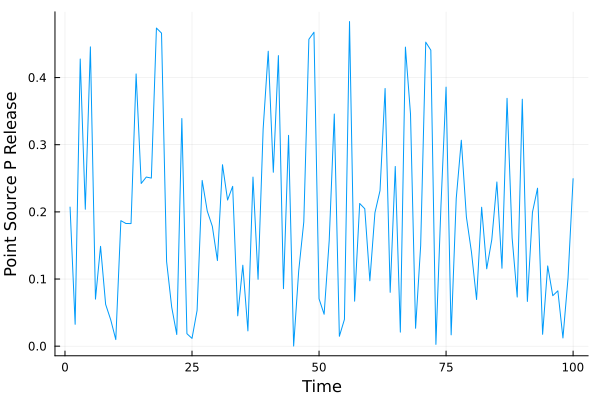

In [40]:
plot(x, xlabel="Time", ylabel="Point Source P Release", legend=false)

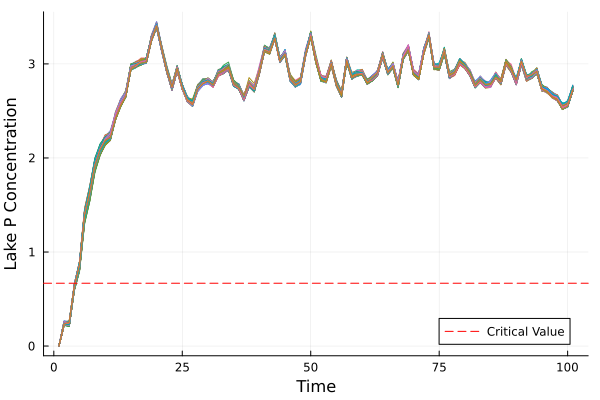

In [41]:
plot(lake_concentration, xlabel="Time", ylabel="Lake P Concentration", label="")
hline!((1:T, Xcrit), line=:red, linestyle=:dash, label="Critical Value", legend=true)

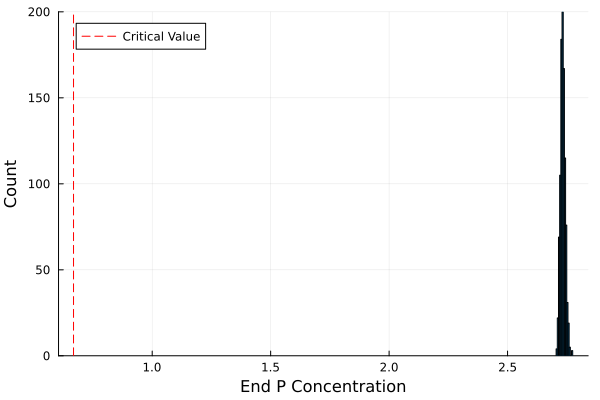

In [42]:
histogram(lake_concentration[end, :], xlabel="End P Concentration", ylabel="Count", label="")
vline!((1:T, Xcrit), line=:red, linestyle=:dash, label="Critical Value", legend=true)

### Problem 2 (5 points)

Feel free to experiment with some of the degrees of freedom in finding
the optimum value. For example:

-   What failure probability are you using to characterize acceptable
    solutions?
-   How many Monte Carlo samples are you using?
-   What bounds are you searching over for the releases?
-   How many function evaluations are you using for the search?
-   What is the impact of different [`Metaheuristics.jl`
    algorithms](https://docs.juliahub.com/Metaheuristics/aJ70z/3.2.12/algorithms/)?

Note that you might want to modify some of these together: for example,
lower acceptable failure probabilities often require more function
evaluations to find acceptable values, and more Monte Carlo samples
increase computational expense, so fewer function evaluations may be
completed in the same time.

Provide a description of what you’ve modified and why. What was the new
solution that you found? Does it satisfy the constraints?

In [ ]:
function eval_lake(T, n_samples)
    #Random.seed!(1)

    #T = 100 # length of simualtion
    #n_samples = 100 # replace with number of samples if you experiment
    P_distribution = LogNormal(log(0.03), 0.25)
    y = rand(P_distribution, (T, n_samples)) # sample a T x n_samples matrix
    q = 2.5
    b = 0.4
    Xcrit = find_zero(P_flux, (0.1, 1.5))


    max_evals = 5000
    bounds = [zeros(T) 0.5ones(T)]'
    results = optimize(a -> lake_opt(a, y, q, b, T, Xcrit),
        bounds, DE(options=Options(f_calls_limit=max_evals)))

    fx = minimum(results)
    x = minimizer(results)
    return x
end
eval_lake(100, 100)

In [ ]:
T = 100
n_iterations = 100:10:699
lake_vector = zeros(T, length(n_iterations))
for (i, n) in enumerate(n_iterations)
    lake_vector[:, i] = eval_lake(T, n)
end

In [ ]:
lake_concentration = zeros(T+1, length(n_iterations))
for i in 1:length(lake_vector[1,:])
lake_i = lake(lake_vector[:,i], y, q, b, 100)[:,end]
    lake_concentration[:,i] = lake_i
end

In [ ]:
plot(lake_vector, xlabel="Time", ylabel="Point Source P Release", legend=false)

In [ ]:
plot(sum(lake_vector, dims=2)./length(n_iterations), xlabel="Time", ylabel="Point Source P Release", legend=false)

In [ ]:
histogram(lake_vector[end,:], bins=length(lake_vector[1,:]), xlabel="End P Concentration", ylabel="Count", legend=false)
vline!((1:T, Xcrit))

In [ ]:
plot(lake_concentration, xlabel="Time", ylabel="Lake P Concentration", legend=false)
hline!((1:T, Xcrit))

In [ ]:
histogram(lake_concentration[:,end], xlabel="Time", ylabel="Lake P Concentration", legend=false)


In [ ]:
histogram(lake_concentration[end, :])

In [ ]:
histogram(sum(lake_vector, dims=2)./length(n_iterations), bins=length(lake_vector[:,1]), legend=false)

In [ ]:
histogram(sum(lake_concentration, dims=2)./length(n_iterations), bins=length(lake_concentration[:,1]), legend=false)

In [ ]:
count(i -> i > Xcrit, lake_vector[end, :])

In [ ]:
count(i -> i <= Xcrit, lake_concentration[:, end])

In [ ]:
plot(P_flux.(lake_concentration), xlabel="Time", ylabel="Lake P Flux",  legend=false)

### Problem 3 (3 points)

What did you learn about the use of these methods? Compare with your
experience with linear programming from earlier in the semester.

problem 3 here

## References

Put any consulted sources here, including classmates you worked with/who
helped you.